# This notebook we're going to see:
<ul>
    <li>finding the MSR</li>
    <li>Using a Minimizer to set weights</li>
</ul>  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import datetime
import risk_kit as erk
import seaborn as sns
%matplotlib inline

c:\users\home_041\miniconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# auto reload imported modules
%load_ext autoreload
%autoreload 2

In [3]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

# Importing data

### creating msr function

In [4]:
def msr(riskfree_rate,er, cov):
    """
    RiskFree rate + ER + COV -> weight vector
    """
    
    n = er.shape[0]
    
    #init guess
    init_guess = np.repeat(1/n, n)
    
    #bounds minimum of 0 maximun of 1, for n assets
    bounds = ((0.0,1),)*n
    #constrain to stop the function when met the espected return
   
    #constrain to set the sum of weights to 1
    weights_sum_to_1= {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1        
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        returns the negative of the sharpe ratio, given weights
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess ,
                       args=(riskfree_rate, er,cov,),
                       method='SLSQP',
                       options={'disp': False},
                       constraints =(weights_sum_to_1),
                       bounds = bounds
                      )
    return results.x


In [5]:
from scipy.optimize import minimize 

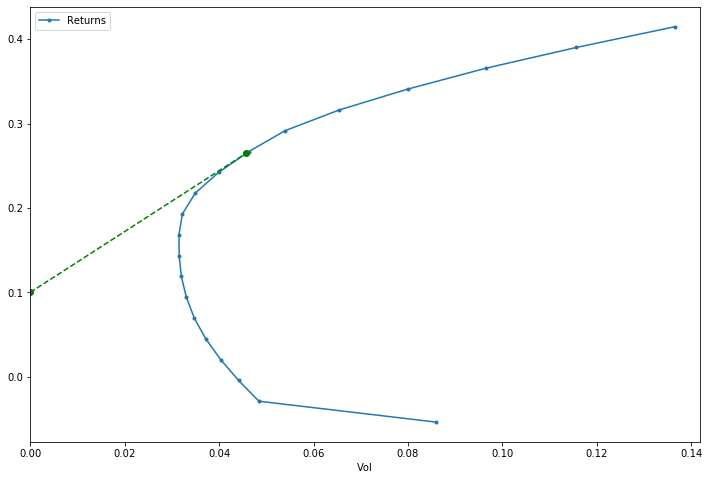

In [6]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
rf = 0.1 #riskfree as 10%
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# add CML (capital market line)

cml_x = [0, vol_msr]
cml_y = [rf, r_msr]

ax.plot(cml_x, cml_y, color = 'green', marker = 'o', linestyle = 'dashed')

### What means the MSR and The Capital market line ?


#### given the free risk of the period we calculate the best sharpe ratio portifolio

### Analyzing the Portfolio

In [7]:
ind.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

In [36]:
w_msr

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.48932500e-15,
       0.00000000e+00, 0.00000000e+00, 5.45480127e-15, 4.55961462e-01,
       8.10280096e-16, 2.15496315e-15, 2.67314408e-15, 1.97311109e-15,
       1.52936446e-15, 2.33810838e-01, 2.14489135e-15, 0.00000000e+00,
       9.01619313e-15, 1.38704167e-01, 0.00000000e+00, 8.94091715e-02,
       0.00000000e+00, 2.13532897e-15, 1.55177068e-02, 6.11494428e-16,
       2.46290006e-15, 0.00000000e+00, 6.65966553e-02, 1.35272882e-15,
       0.00000000e+00, 1.93143388e-15])

#### 1 - Create a list of lists

In [37]:
w_msr_l = []
for i in w_msr:
    print(i)
    w_msr_l.append([i,])

0.0
0.0
0.0
6.489325001664381e-15
0.0
0.0
5.454801270135319e-15
0.4559614617911977
8.102800964197282e-16
2.154963145098785e-15
2.6731440825032812e-15
1.973111090644948e-15
1.5293644612845693e-15
0.23381083793034532
2.1448913450231765e-15
0.0
9.016193131153212e-15
0.13870416671524358
0.0
0.08940917147024423
0.0
2.1353289674543483e-15
0.015517706798418497
6.114944278336846e-16
2.4629000578223284e-15
0.0
0.06659665529454163
1.352728818322731e-15
0.0
1.9314338789030984e-15


#### 2 - zip it into a dictionary

In [38]:
dict_data= dict(zip(ind.columns, w_msr_l))


#### 3- create a dataframe

In [52]:
df_best_port = pd.DataFrame(dict_data)
df_best_port

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
0,0.0,0.0,0.0,6.489325e-15,0.0,0.0,5.454801e-15,0.455961,8.102801e-16,2.154963e-15,...,0.0,2.135329e-15,0.015518,6.114944e-16,2.462900e-15,0.0,0.066597,1.352729e-15,0.0,1.931434e-15


#### 4 - selecting only the values higher than the threshold

In [162]:
df_thresh =df_best_port[ df_best_port>= 0.005].dropna(axis = 1)
#columns
df_thresh.columns
#values 
df_thresh.loc[0]

Hlth     0.455961
ElcEq    0.233811
Coal     0.138704
Util     0.089409
BusEq    0.015518
Rtail    0.066597
Name: 0, dtype: float64

#### 5 - multiplying returns by the weight vector 

In [163]:
(ind['1996':'2000'][df_thresh.columns]+1).cumprod()*df_thresh.loc[0]

,Hlth,ElcEq,Coal,Util,BusEq,Rtail
1996-01,0.483091,0.246203,0.135458,0.091117,0.015851,0.065624
1996-02,0.477922,0.244332,0.137924,0.088766,0.016924,0.069253
1996-03,0.479069,0.251710,0.144172,0.088349,0.016146,0.074967
1996-04,0.476195,0.252667,0.145094,0.086061,0.017851,0.078235
1996-05,0.494909,0.268282,0.167918,0.087222,0.018597,0.082233
1996-06,0.493969,0.276733,0.183618,0.091767,0.017416,0.081345
1996-07,0.464034,0.263560,0.168231,0.086426,0.016110,0.075147
1996-08,0.483477,0.267909,0.170182,0.088924,0.016927,0.080324
1996-09,0.518965,0.294727,0.187762,0.089519,0.018726,0.082967
1996-10,0.515436,0.311556,0.189696,0.092751,0.018490,0.081341


In [ ]:
6 - creating a columns with sum of the weights

In [167]:
ind['sum_w'] = ((ind['1996':'2000'][df_thresh.columns]+1).cumprod()*df_thresh.loc[0]).sum(axis =1)
ind['1996':'2000']['sum_w']

1996-01    1.037345
1996-02    1.035122
1996-03    1.054413
1996-04    1.056103
1996-05    1.119162
1996-06    1.144848
1996-07    1.073508
1996-08    1.107743
1996-09    1.192666
1996-10    1.209269
1996-11    1.279827
1996-12    1.273616
1997-01    1.368778
1997-02    1.365158
1997-03    1.294301
1997-04    1.376887
1997-05    1.449127
1997-06    1.546640
1997-07    1.637610
1997-08    1.534443
1997-09    1.611929
1997-10    1.545765
1997-11    1.616963
1997-12    1.655414
1998-01    1.697726
1998-02    1.780491
1998-03    1.885497
1998-04    1.896075
1998-05    1.859958
1998-06    1.956541
1998-07    1.949476
1998-08    1.705287
1998-09    1.820209
1998-10    1.924414
1998-11    2.033277
1998-12    2.214058
1999-01    2.277275
1999-02    2.254626
1999-03    2.425957
1999-04    2.440758
1999-05    2.352440
1999-06    2.389868
1999-07    2.281097
1999-08    2.356882
1999-09    2.283563
1999-10    2.555047
1999-11    2.543557
1999-12    2.710306
2000-01    2.801264
2000-02    2.748204


Total return of the weighted portfolio: 3.34


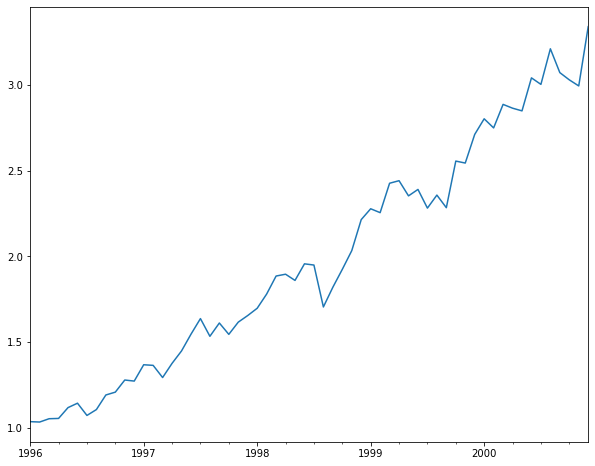

In [186]:
plt.figure(figsize = (10,8))
ind['1996':'2000']['sum_w'].plot()
print("Total return of the weighted portfolio: {:.3}".format(ind['1996':'2000']['sum_w'].iloc[-1]))

### plotting drawdowns

In [189]:
ret = ind['1996':'2000']['sum_w']

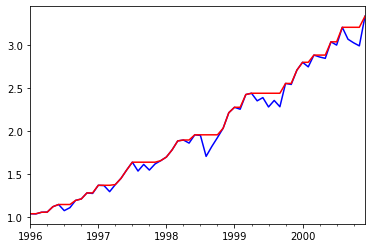

In [195]:
ret.plot(c = 'b')
ret.cummax().plot(c = 'r')

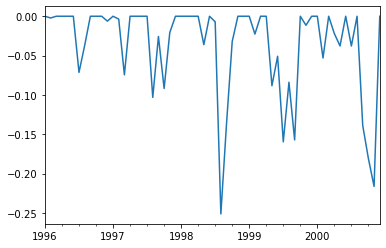

In [197]:
(ret-ret.cummax()).plot()

### std
<p> standard deviation of the population</p>

In [221]:
pct_ret = (ret.pct_change())
std_ret = pct_ret.std(ddof=0)
std_ret

0.04706298633977056

#### ret semi deviation
<p> standard deviation only with negative returns </p>

In [225]:
neg_pct_ret = pct_ret[pct_ret <= 0].std()
neg_pct_ret 

0.02954802477900107

In [229]:
np.percentile(pct_ret, 5)

nan

In [233]:
np.percentile(pct_ret.dropna(), 5)

-0.0529445623151042

with 95% of confidence the portifolio can present max losses of 5,29% over that period in one mounth

### VaR = Cornish- Fisher

In [239]:
def var_gaussian(r, level = 5, modified = False):
    """
    Returns a Gaussian Value at Risc at specified Level
    if modified == True, returns a Modified Cornish-Fischer adjusting the z factor
    """
    z = norm.ppf(level/100)
    
    if modified:
        s = erk.skewness(r)
        k = erk.kurtosis(r)
        z = (z + 
                 (z**2 -1)*s/6 +
                 (z**3 -3*z)*(k-3)/24 -
                 (2*z**3 -5*z)*(s**2)/36
            )
    return -(r.mean()+z*r.std(ddof=0))

In [242]:
from scipy.stats import norm
-var_gaussian(pct_ret,5, modified=True)

-0.06167126672437889